## Summary

Results of deep mutation scanning experiments.

---

## Imports

In [113]:
import gzip
import os
import re
import shutil
import tempfile
import urllib.request
from collections import defaultdict
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import requests
import yaml
from elaspic2.plugins.proteinsolver.protein_data import extract_seq_and_adj
from IPython.display import SVG
from kmbio import PDB
from kmtools import sequence_tools, structure_tools
from scipy import stats
from tqdm.notebook import tqdm

In [2]:
pd.set_option("max_rows", 1000)
pd.set_option("max_columns", 1000)

## Parameters

In [3]:
NOTEBOOK_DIR = Path("08_mechismo_dunham_2020").resolve()
NOTEBOOK_DIR.mkdir(exist_ok=True)

NOTEBOOK_DIR

PosixPath('/home/kimlab4/strokach/workspace/elaspic2/notebooks/08_mechismo_dunham_2020')

In [4]:
if "DATAPKG_OUTPUT_DIR" in os.environ:
    OUTPUT_DIR = Path(os.getenv("DATAPKG_OUTPUT_DIR")).joinpath("protein-folding-energy").resolve()
else:
    OUTPUT_DIR = NOTEBOOK_DIR.parent
OUTPUT_DIR.mkdir(exist_ok=True)

display(OUTPUT_DIR)

PosixPath('/home/kimlab1/database_data/datapkg_output_dir/protein-folding-energy')

## Common

In [7]:
def structure_to_blob(structure):
    with tempfile.NamedTemporaryFile(suffix=".pdb") as out:
        PDB.save(structure, out.name)
        with open(out.name, "rt") as fin:
            data = fin.read()
    return data

In [8]:
def sequence_matches_structure(sequence, structure_blob):
    with tempfile.NamedTemporaryFile(suffix=".pdb") as tmp_file:
        with open(tmp_file.name, "wt") as fout:
            fout.write(structure_blob)
        structure = PDB.load(tmp_file.name)

    chain_sequence = structure_tools.get_chain_sequence(
        structure[0]["A"], if_unknown="replace", unknown_residue_marker=""
    )
    return sequence == chain_sequence

In [37]:
def map_to_target(seq1, muts1, seq2):
    seq1_aln, seq2_aln = sequence_tools.align_pairwise(seq1, seq2)

    muts1_dict = defaultdict(list)
    for mut in muts1:
        muts1_dict[int(mut[1:-1]) - 1].append(mut)

    muts2 = {}
    idx1 = 0
    idx2 = 0
    for aa1, aa2 in zip(seq1_aln, seq2_aln):
        if aa1 != "-" and aa1 == aa2 and idx1 in muts1_dict:
            for mut in muts1_dict[idx1]:
                if mut[0] != aa1:
                    print("x")
                    continue
                muts2[f"{mut[0]}{idx2 + 1}{mut[-1]}"] = mut

        if aa1 != "-":
            idx1 += 1
        if aa2 != "-":
            idx2 += 1

    assert idx1 == len(seq1)
    assert idx2 == len(seq2)

    return muts2

In [52]:
def compute_spearman_ci(rho, n):
    # https://stackoverflow.com/a/30393477/2063031
    z = np.arctanh(rho)
    sigma = 1 / ((n - 3) ** 0.5)
    cint = z + np.array([-1, 1]) * sigma * stats.norm.ppf((1 + 0.95) / 2)
    lower, upper = np.tanh(cint)
    return lower, upper

In [53]:
def bootstrap_confidence_interval(
    values1, values2, fn, num_iterations=1_000, show_progress=True, seed=42
):
    rng = np.random.default_rng(seed)
    outputs = []
    for _ in tqdm(range(num_iterations), disable=not show_progress):
        index = rng.choice(len(values1), len(values1), replace=True)
        while len(np.unique(index)) == 1:
            index = rng.choice(len(values1), len(values1), replace=True)
        values1_sample = values1[index]
        values2_sample = values2[index]
        output = fn(values1_sample, values2_sample)
        outputs.append(output)
    lower = np.quantile(outputs, 0.05)
    upper = np.quantile(outputs, 0.95)
    return lower, upper, outputs

## Load data

In [26]:
affinity_df = pq.read_table(OUTPUT_DIR.joinpath("dunham_2020_tianyu", "dimers.parquet")).to_pandas()

In [27]:
display(affinity_df)

,dataset,name,protein_sequence,ligand_sequence,mutation,effect,effect_type,protein_structure
0,dunham_2020_tianyu,hartman_2018_cp|CP,ASNFTQFVLVDNGGTGDVTVAPSNFANGVAEWISSNSRSQAYKVTC...,ASNFTQFVLVDNGGTGDVTVAPSNFANGVAEWISSNSRSQAYKVTC...,"[S2A, S2C, S2D, S2E, S2F, S2G, S2H, S2I, S2K, ...","[-0.07283412012502793, -1.0104825874636678, -0...",Deep mutation scan,ATOM 1 N ALA A 1 55.739 26.043...
1,dunham_2020_tianyu,heredia_2018_cxcr4|CXCR4,PCFREENANFNKIFLPTIYSIIFLTGIVGNGLVILVMGYQKKLRSM...,CFREENANFNKIFLPTIYSIIFLTGIVGNGLVILVMGYQKKLRSMT...,"[P1A, P1C, P1D, P1E, P1F, P1G, P1H, P1I, P1K, ...","[-0.1719955756776495, -0.6891373682332023, -0....",Deep mutation scan,ATOM 1 N PRO A 37 7.282 -8.921...
2,dunham_2020_tianyu,melnikov_2014_aph3ii|APH3II,GSPAAWVERLFGYDWAQQTIGCSDAAVFRLSAQGRPVLFVKTDLSG...,GSPAAWVERLFGYDWAQQTIGCSDAAVFRLSAQGRPVLFVKTDLSG...,"[G1A, G1C, G1D, G1E, G1F, G1H, G1I, G1K, G1L, ...","[0.3153683479001544, -0.001563688975571187, 0....",Deep mutation scan,ATOM 1 N GLY A 10 -18.728 -22.084...
3,dunham_2020_tianyu,starita_2015_brca1|BRCA1,MDLSALRVEEVQNVINAMQKILECPICLELIKEPVSTKCDHIFCKF...,MEPDGRGAWAHSRAALDRLEKLLRCSRCTNILREPVCLGGCEHIFC...,"[L3A, L3C, L3D, L3E, L3F, L3G, L3H, L3I, L3K, ...","[-0.2499683444913821, -0.6573302132706103, -1....",Deep mutation scan,ATOM 1 N MET A 1 4.480 28.757...
4,dunham_2020_tianyu,sun_2018_cbs|CBS,PLWIRPDAPSRCTWQLGRPASESPHHHTAPAKSPKILPDILKKIGD...,PLWIRPDAPSRCTWQLGRPASESPHHHTAPAKSPKILPDILKKIGD...,"[P1A, P1C, P1D, P1E, P1F, P1G, P1H, P1I, P1K, ...","[-0.05922567099526903, -0.05922567099526903, -...",Deep mutation scan,ATOM 1 N PRO A 41 -13.000 -39.465...
5,dunham_2020_tianyu,weile_2017_sumo1|SUMO1,GSMSDQEAKPSTEDLGDKKEGEYIKLKVIGQDSSEIHFKVKMTTHL...,GQDRFVYTCNECKHHVETRWHCTVCEDYDLCINCYNTKSHAHKMVK...,"[M3A, M3C, M3D, M3E, M3F, M3G, M3H, M3I, M3K, ...","[-0.17849551455979898, -0.2510913991366985, -0...",Deep mutation scan,ATOM 1 N GLY A 1 25.378 -17.009...
6,dunham_2020_tianyu,weile_2017_tpk1|TPK1,MEHAFTPLEPLLSTGNLKYCLVILNQPLDNYFRHLWNKALLRACAD...,MEHAFTPLEPLLSTGNLKYCLVILNQPLDNYFRHLWNKALLRACAD...,"[M1A, M1C, M1D, M1E, M1F, M1G, M1H, M1I, M1K, ...","[-0.3289609762124538, -0.29989317044894953, -0...",Deep mutation scan,ATOM 1 N MET A 1 25.241 70.723...
7,dunham_2020_tianyu,weile_2017_ube2i|UBE2I,GSHMSGIALSRLAQERKAWRKDHPFGFVAVPTKNPDGTMNLMNWEC...,YIKLKVIGQDSSEIHFKVKMTTHLKKLKESYCQRQGVPMNSLRFLF...,"[M4A, M4C, M4D, M4E, M4F, M4G, M4H, M4I, M4K, ...","[-0.4579539285841058, -0.3587841758398825, -0....",Deep mutation scan,ATOM 1 N GLY A 1 -1.177 10.339...


### Save files for running Mechismo

In [42]:
mutation_mapping = {}
for tup in affinity_df.itertuples():
    dataset = tup.name.split("|")[0]
    data = yaml.load(
        requests.get(
            f"https://raw.githubusercontent.com/allydunham/aa_subtypes/master/data/studies/{dataset}/{dataset}.yaml"
        ).text,
        Loader=yaml.SafeLoader,
    )

    seq1 = tup.protein_sequence
    muts1 = tup.mutation
    seq2 = data["seq"]
    muts2 = map_to_target(seq1, muts1, seq2)
    mutation_mapping[dataset] = muts2
    print(dataset, len(muts2) / len(muts1))

    uniprot_id = data["uniprot_id"]
#     with NOTEBOOK_DIR.joinpath(f"{dataset}.txt").open("wt") as fout:
#         for mut in muts2:
#             fout.write(f"{uniprot_id}/{mut}\n")

hartman_2018_cp 1.0
heredia_2018_cxcr4 1.0
melnikov_2014_aph3ii 1.0
starita_2015_brca1 1.0
sun_2018_cbs 0.9979838709677419
weile_2017_sumo1 1.0
weile_2017_tpk1 1.0
weile_2017_ube2i 1.0


In [43]:
!ls {NOTEBOOK_DIR}

hartman_2018_cp.txt	   starita_2015_brca1.tsv.gz  weile_2017_tpk1.tsv.gz
hartman_2018_cp.unk	   starita_2015_brca1.txt     weile_2017_tpk1.txt
heredia_2018_cxcr4.tsv.gz  sun_2018_cbs.tsv.gz	      weile_2017_ube2i.tsv.gz
heredia_2018_cxcr4.txt	   sun_2018_cbs.txt	      weile_2017_ube2i.txt
melnikov_2014_aph3ii.txt   weile_2017_sumo1.tsv.gz
melnikov_2014_aph3ii.unk   weile_2017_sumo1.txt


### Load data

In [63]:
predictions_df = pq.read_table(
    "/home/kimlab4/strokach/workspace/elaspic2/notebooks/06_validate_model/interface/dunham_2020_tianyu.parquet"
).to_pandas(integer_object_nulls=True)

In [64]:
predictions_df.head()

,dataset,name,mutation,effect,effect_type,ddg_pred,elaspic_score,foldx_score,rosetta_complex_dg_change,proteinsolver_interface_score_change,protbert_interface_score_change
0,dunham_2020_tianyu,hartman_2018_cp|CP,T71Q,0.110421,Deep mutation scan,0.445999,NaN,NaN,3.342000,-0.089760,-0.986989
1,dunham_2020_tianyu,hartman_2018_cp|CP,M108D,0.582713,Deep mutation scan,1.602797,NaN,NaN,6.958333,-0.077372,-0.956778
2,dunham_2020_tianyu,hartman_2018_cp|CP,W32P,0.388942,Deep mutation scan,1.256273,NaN,NaN,27.687667,-0.405254,-0.961264
3,dunham_2020_tianyu,hartman_2018_cp|CP,V79L,1.047981,Deep mutation scan,-0.712821,NaN,NaN,-0.639667,-0.008667,-0.976373
4,dunham_2020_tianyu,hartman_2018_cp|CP,S23P,0.402382,Deep mutation scan,1.430518,NaN,NaN,11.636667,-0.159027,-0.987356


### Calculate Mechismo score

In [77]:
# FEATURE = "ie"
# FEATURE = "mechProt"
FEATURE = "mech"

def read_mechanismo_results(tsv_file, partner):
    df = pd.read_csv(tsv_file, sep="\t")
    df["mutation"] = df["res_a1"] + df["pos_a1"].astype(str) + df["mut_a1"]
#     print(set(df["name_b1"]))
#     print(set(df["conf"]))
    if FEATURE == "ie":
        df = df[df["name_b1"] == partner]
#     df = df[df["conf"] == "high"]

    results = []
    for mutation, gp in df.groupby("mutation"):
#         assert len(set(gp[feature])) == 1
        results.append((mutation, gp[FEATURE].mean()))
    return pd.DataFrame(results, columns=["mutation", "mech_score"])

In [78]:
interaction_partners = {
    "heredia_2018_cxcr4": "CCR5",
    "starita_2015_brca1": "BARD1",
    "sun_2018_cbs": "[PROT]",
    "weile_2017_sumo1": "UBE2K",
    "weile_2017_tpk1": "TPK1",
    "weile_2017_ube2i": "UBC",
}

In [79]:
results = []
for tup in affinity_df.itertuples():
    dataset = tup.name.split("|")[0]

    tsv_file = NOTEBOOK_DIR.joinpath(f"{dataset}.tsv.gz")
    if not tsv_file.is_file():
        print(f"Skipping dataset {dataset}")
        continue

    mech_df = read_mechanismo_results(tsv_file, interaction_partners[dataset])
    mech_df["mutation_old"] = mech_df["mutation"].map(mutation_mapping[dataset])
    mech_score = mech_df.set_index("mutation_old")["mech_score"].to_dict()

    for mut in set(tup.mutation):
        if mut in mech_score:
            results.append((tup.dataset, tup.name, mut, mech_score[mut]))
results_df = pd.DataFrame(results, columns=["dataset", "name", "mutation", "mech_score"])

Skipping dataset hartman_2018_cp
Skipping dataset melnikov_2014_aph3ii


In [80]:
if f"mech_{FEATURE}_score" in predictions_df:
    del predictions_df[f"mech_{FEATURE}_score"]

predictions_df = predictions_df.merge(
    results_df.rename(columns={"mech_score": f"mech_{FEATURE}_score"}),
    on=["dataset", "name", "mutation"],
    how="left",
    validate="1:1",
)

### Make plots

In [170]:
feature_columns = [
    ("ddg_pred", +1),
    ("rosetta_complex_dg_change", +1),
    ("proteinsolver_interface_score_change", -1),
    ("protbert_interface_score_change", -1),
    ("mech_mech_score", +1),
    ("mech_mechProt_score", +1),
#     ("mech_ie_score", -1),
]

subset = predictions_df.copy()
subset = subset[subset["mech_mech_score"] != 0]

corrs = {}
for (dataset, name), gp in subset.groupby(["dataset", "name"]):
    gpnn = gp.dropna(subset=[c[0] for c in feature_columns])
    print(f"{name:30} {len(gp)} {len(gpnn)}")
    
    if len(gpnn) < 50:
        print(f"Skipping {name}")
        continue

    corrs[name] = {"num": len(gpnn), "corr": {}}
    for column, sign in feature_columns:
        rho, pvalue = stats.spearmanr(gpnn["effect"], gpnn[column])
        rho = sign * rho
        if pd.isnull(rho):
            print(rho)
            continue

        lower, upper = compute_spearman_ci(rho, len(gpnn))

#         lower, upper, _ = bootstrap_confidence_interval(
#             sign * gpnn[column].values,
#             gpnn["effect"].values,
#             fn=lambda v1, v2: stats.spearmanr(v1, v2)[0],
#             show_progress=False,
#         )

        corrs[name]["corr"][column] = (rho, lower, upper)   

hartman_2018_cp|CP             2337 0
Skipping hartman_2018_cp|CP
heredia_2018_cxcr4|CXCR4       3990 1146
melnikov_2014_aph3ii|APH3II    4845 0
Skipping melnikov_2014_aph3ii|APH3II
starita_2015_brca1|BRCA1       893 893
sun_2018_cbs|CBS               760 45
Skipping sun_2018_cbs|CBS
weile_2017_sumo1|SUMO1         950 950
weile_2017_tpk1|TPK1           798 621
weile_2017_ube2i|UBE2I         1558 1558


In [164]:
methods = {
    "ddg_pred": "EL2 interface",
    "elaspic_score": "ELASPIC",
    "foldx_score": "FoldX",
    "rosetta_dg_change": "Rosetta",
    "rosetta_complex_dg_change": "Rosetta",
    "provean_score": "Provean",
    "mcsm": "mCSM",
    "popmusic": "PoPMuSiC",
    "proteinsolver_core_score_change": "ProteinSolver",
    "proteinsolver_interface_score_change": "ProteinSolver",
    "protbert_core_score_change": "ProtBert",
    "protbert_interface_score_change": "ProtBert",
    "mech_mech_score": "Mechismo (mech)",
    "mech_mechProt_score": "Mechismo (mechProt)",
    "mech_ie_score": "Mechismo (IE)",
}

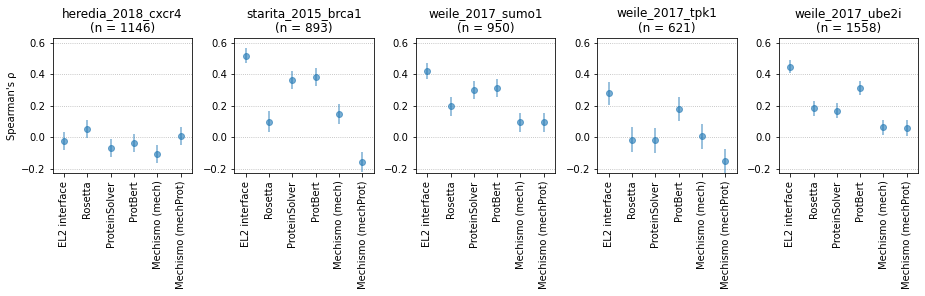

In [171]:
fg, axs = plt.subplots(1, len(corrs), figsize=(0.5 + 2.5 * len(corrs), 4))

for i, (name, info) in enumerate(corrs.items()):
    ax = axs[i]
    x = np.arange(len(info["corr"].keys()))
    rects = ax.errorbar(
        x,
        np.array([c[0] for c in info["corr"].values()]),
        fmt="o",
        alpha=0.6 if column not in ["network_score_change"] else 1.0,
        yerr=[
            [c[0] - c[1] for c in info["corr"].values()],
            [c[2] - c[0] for c in info["corr"].values()],
        ],
        # label=methods[name],
    )
    ax.set_title(f"{name.split('|')[0]}\n(n = {info['num']})")
    ax.set_xticks(x)
    ax.set_xticklabels([methods[m] for m in info["corr"].keys()], rotation=90)
    ax.set_xlim(x[0] - 0.5, x[-1] + 0.5)
    ax.set_ylim([-0.23, 0.63])
    if i == 0:
        ax.set_ylabel("Spearman's ρ")

#     ax.spines["top"].set_visible(False)
#     ax.spines["right"].set_visible(False)
#     ax.spines["left"].set_visible(False)
    ax.grid(axis="y", linestyle=":")
    
fg.subplots_adjust(left=0.06, bottom=0.41, top=0.88, right=0.985, wspace=0.3)

if "mech_ie_score" in info["corr"]:
    suffix = "-with-ie"
else:
    suffix = ""
fg.savefig(NOTEBOOK_DIR.joinpath(f"dunham-2020-mechismo{suffix}.svg"), dpi=300)
fg.savefig(NOTEBOOK_DIR.joinpath(f"dunham-2020-mechismo{suffix}.png"), dpi=300)
fg.savefig(NOTEBOOK_DIR.joinpath(f"dunham-2020-mechismo{suffix}.pdf"), dpi=300)

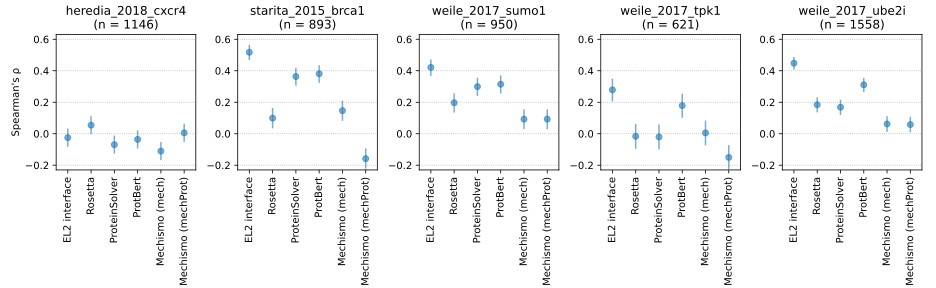

In [172]:
SVG(NOTEBOOK_DIR.joinpath(f"dunham-2020-mechismo{suffix}.svg"))